In [1]:
#数据预处理
%matplotlib inline
import numpy as np
#import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno

#不加下面这一步进程很容易中断
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["OMP_NUM_THREADS"] = '9' 

#---------------------------------------------------
import sklearn
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
#加载模型：
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#---------------------------
from sklearn.model_selection import GridSearchCV

In [2]:
#网络调参函数
def get_model(name):
    if name=="SVC":
        clf=GridSearchCV(
            svm.SVC(),
            {
                #核
                "kernel": ['linear', "poly"],
                #惩罚系数
                "C": [0.01,0.1,1]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="DT":
        clf=GridSearchCV(
            tree.DecisionTreeClassifier(),
            {
                #划分方式
                "criterion": ['entropy',"gini"],#前者是基尼系数，后者是信息熵
                #z最大深度
                "max_depth": [2,10,50,100,200,500] ,
                #可以分支的最少样本数
                "min_samples_split": [1,5,10,20] ,
                #叶节点最小样本数
                "min_samples_leaf": [1,5,10,20] ,
                #信息增益最小值
                "min_impurity_decrease": [0.001,0.01]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="LR":
        clf = GridSearchCV(
            linear_model.LogisticRegression(),
            {
                "penalty":[None,'l2',"l1"],
                "C":[1,2,3,4,5,6,7,8,9,10],
                "solver":["newton-cg", "lbfgs", "liblinear", "sag"],
                "class_weight":["balanced",None]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="NB":
        clf = GridSearchCV(
            GaussianNB(),
            {},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
        
    if name=="KNN":
        clf = GridSearchCV(
            KNeighborsClassifier(),
            {
                "n_neighbors": [3,5,10,12]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="RF":
        clf = GridSearchCV(
            RandomForestClassifier(),
            {
                "n_estimators" : [10,20,30,50,80],
                "criterion" : ["entropy","gini"],
                "max_depth" : [4,8,12,None],
                "min_samples_split" : [2,5,10],
                "min_samples_leaf" : [1,5,10,20]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="XB":
        clf=GridSearchCV(
            XGBClassifier(),
            {
                "n_estimators":[10,30,60],  # 树的个数-10棵树建立xgboost
                "max_depth":[3,5,6,7,9,12],  # 树的深度[4,8,12]
                "min_child_weight":[0.1,0.5,1],#叶子上最小样本数,值越大，越容易欠拟合；值越小，越容易过拟合
                "scale_pos_weight":[2.4,2.5],#各类别样本十分不平衡时，把这个参数设定为一个正值
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    return clf

In [3]:
#一些函数
# get_train_test
# get_dat->train_model
# model

#获得划分后的数据
def get_train_test(df,fold,seed):
    # 获取数据总行数
    nums = df.shape[0]
    # 将数据分成5份 if fold=5
    chunk_size = nums // fold
    print("样本总数：",nums)
    print("划分后每折样本数：",chunk_size)

    # 将数据打乱顺序  并  划分
    df_shuffled = df.sample(frac=1, random_state=seed)
    chunks = [df_shuffled.iloc[i:i + chunk_size] for i in range(0, nums, chunk_size)]

    if fold==3:
        train = [pd.concat([chunks[0],chunks[1]]),
                 pd.concat([chunks[0],chunks[2]]),
                 pd.concat([chunks[1],chunks[2]]),
                ]
        test = [chunks[2],chunks[1],chunks[0]]
        
    
    #获得五组训练集和训练集
    if fold==5:
        train = [pd.concat([chunks[0],chunks[1],chunks[2],chunks[3]]),
                 pd.concat([chunks[0],chunks[1],chunks[2],chunks[4]]),
                 pd.concat([chunks[0],chunks[1],chunks[3],chunks[4]]),
                 pd.concat([chunks[0],chunks[2],chunks[3],chunks[4]]),
                 pd.concat([chunks[1],chunks[2],chunks[3],chunks[4]]),
                ]
        test = [chunks[4],chunks[3],chunks[2],chunks[1],chunks[0]]
    return train,test

#获得分折好的数据集
def get_data(data,name):
    train_data = data #train[0] / test[0]
    target_name = name #"y4"
    #读
    df= train_data
    features=df.columns.tolist()
    features.remove( target_name )
    y=df[ target_name ]
    X=df[features].values
    return X,y

#获得用于绘制ROC的clf X y
def train_model(data_num,target_name,**dic):
    """
    data_num: 0~5
    target_name: str
    **dic: dic["name"]-> name of model
           ......
    #传参
    # https://blog.csdn.net/yyykj/article/details/103122665
    """
    #读取数据------train
    X,y = get_data(train[data_num],target_name)

    #训练模型---------------------------------------------------可添加
    #if dic["name"]=="SVC":
    #    clf = svm.SVC( kernel=dic["kernel"], C=dic["C"])
    #    clf.fit(X, y)    
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    #clf.grid_scores_, clf.best_params_, clf.best_score_
    
    #读取数据------test
    X,y = get_data(test[data_num],target_name)
    return clf,X,y #用于后续进行ROC画图


#这个是 非多折交叉验证的建模
def train_model_(df1,df2,target_name,**dic):
    #读取数据------train
    X,y = get_data(df1,target_name)
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    #clf.grid_scores_, clf.best_params_, clf.best_score_
    
    #读取数据------test
    X,y = get_data(df2,target_name)
    return clf,X,y #用于后续进行ROC画图

In [4]:
flag = 1

if flag == 1:
    #读取最开始的数据
    fpath="./data/norm_3_train_med.xlsx"
    df=pd.read_excel(fpath)
    df = df[df.columns.tolist()[1:]]


    #用于在独立测试集上检验
    fpath="./data/norm_3_train_med.xlsx"
    df1=pd.read_excel(fpath)
    df1 = df1[df1.columns.tolist()[1:]]

    fpath="./data/norm_4_test_med.xlsx"
    df2=pd.read_excel(fpath)
    df2 = df2[df2.columns.tolist()[1:]]
    
    df.drop('随访>3', axis=1, inplace=True)
    df1.drop('随访>3', axis=1, inplace=True)
    df2.drop('随访>3', axis=1, inplace=True)

----------------------------seed: 1
样本总数： 160
划分后每折样本数： 53
SVC 0.65
LR 0.67
KNN 0.67
NB 0.73
DT 0.66
RF 0.72
XB 0.69
##############
SVC 0.55
LR 0.55
KNN 0.52
NB 0.51
DT 0.59
RF 0.62
XB 0.66


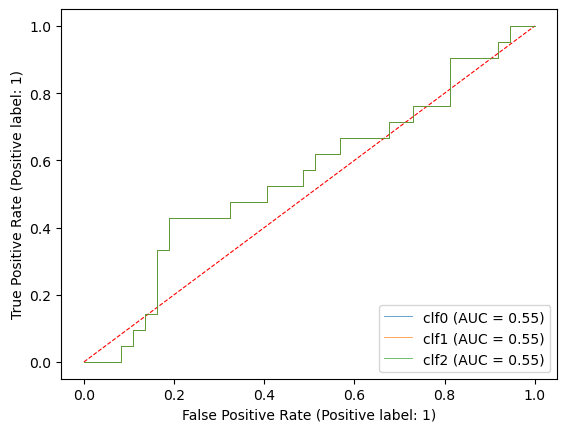

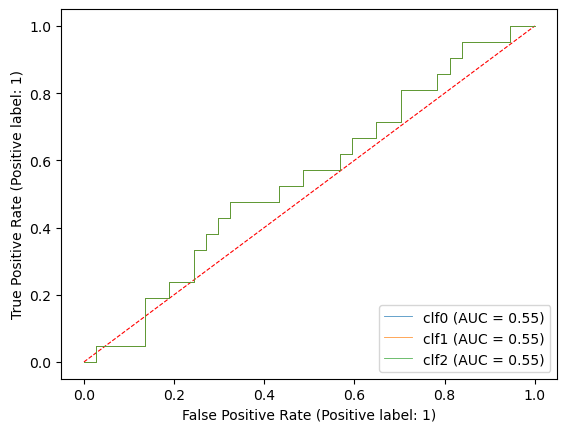

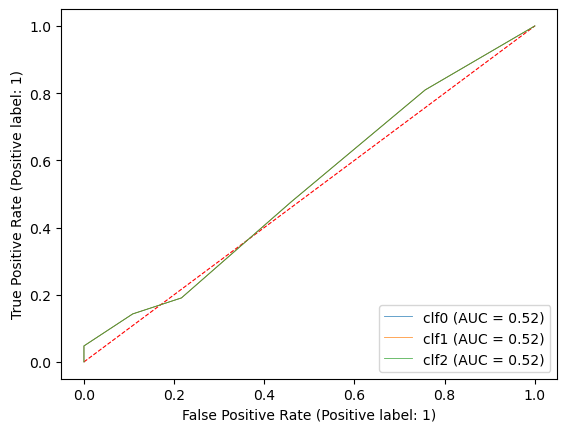

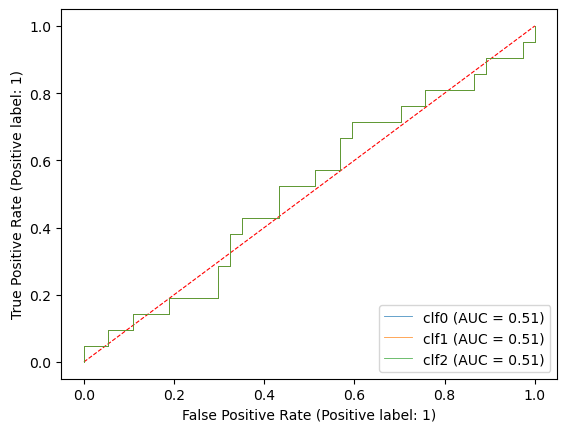

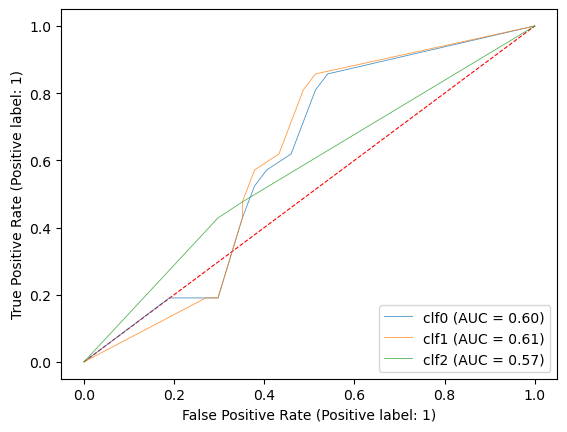

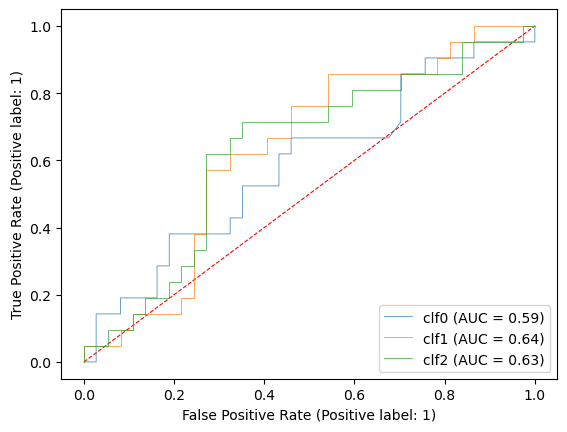

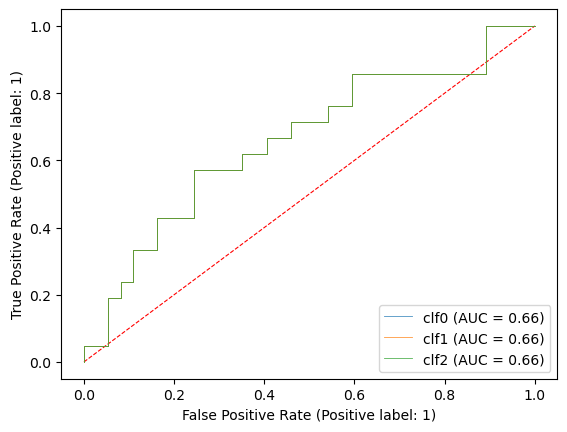

In [9]:
warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in [1]:#range(0,50):
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    auc_record = []

    for i in ["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        #fig, ax = plt.subplots()
        #ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
    
    #"""
    auc_record_ = []
    print("##############")
    for i in ["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""